<a href="https://colab.research.google.com/github/Fidelisaboke/robust-nids/blob/feat%2Fbaseline-model/04_baseline_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Required Libraries

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Standard library for mathematical operations
import math

# Random number generation
import random

# Progress
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split + Tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Scaling and Encoding
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Imbalance handling
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Scikit-Learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

# Tensorflow - For Autoencoder (AEs)
import tensorflow as tf
from tensorflow.keras import layers, models

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    make_scorer
)


# For saving models
import joblib

## Constants and Configuration

In [ ]:
# Clean CSV Path
CLEAN_CSV_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/cleaned_data.csv"

# Scaler
SCALER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/scaler.pkl"

# Label Encoder
LABEL_ENCODER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/label_encoder.pkl"

# Binary Classifier Path
BINARY_CLASSIFIER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/binary_classifier.pkl"

# Multilabel Classifier Path
MULTILABEL_CLASSIFIER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifcats/multilabel_classifier.pkl"

## Load the Dataset

In [ ]:
df = pd.read_csv(CLEAN_CSV_PATH)
df.head()

,Flow Duration,Flow Bytes/s,Flow Packets/s,Fwd Packet Length Max,Fwd Packet Length Min,Packet Length Std,Bwd Init Win Bytes,FWD Init Win Bytes,Fwd Seg Size Min,Idle Std,Idle Mean,SYN Flag Count,ACK Flag Count,Total Fwd Packet,Total Bwd packets,Label,Traffic Type,Traffic Subtype
0,52601173.0,5522.709541,66.424374,1318.0,0.0,93.643930,2068.0,65280.0,32.0,0.000000,0.0,2.0,3493.0,1701.0,1793.0,0,Audio,Audio
1,119106942.0,24.599742,0.780811,41.0,0.0,27.063135,502.0,502.0,32.0,1737.400069,5001511.0,0.0,93.0,36.0,57.0,0,Audio,Audio
2,5589.0,22186.437645,357.845768,124.0,124.0,71.591433,502.0,501.0,32.0,0.000000,0.0,0.0,2.0,1.0,1.0,0,Audio,Audio
3,118166562.0,5969.142100,68.784264,1348.0,0.0,133.693257,4708.0,65280.0,32.0,0.000000,0.0,2.0,8127.0,3932.0,4196.0,0,Audio,Audio
4,119988385.0,4459.064934,56.838835,9.0,9.0,17.228724,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,25.0,6795.0,0,Audio,Audio


## Supervised Learning - Binary Classification

### Separate features from labels

In [ ]:
X = df.drop(columns=["Label", "Traffic Type", "Traffic Subtype"])
y = df["Label"] # Target for binary classification

### Train-test split
- Split: 70% training, 15% testing, 15% validation
- Statification is applied to preserve class balance

In [ ]:
# Split into train (70%) and val + test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the 30% into val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (137295, 15)
Validation size: (29420, 15)
Test size: (29421, 15)


### Feature Scaling


In [ ]:
# Create scaler instance
scaler = MinMaxScaler()

# Fit on X_train, transform X_train, X_val, X_test
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Save the scaler for use later

In [ ]:
try:
  joblib.dump(scaler, SCALER_PATH)
  print(f"Scaler saved to: {SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/scaler.pkl


### Model Training and Validation
- The following classifiers will be trained to establish a fair baseline:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. SVM (RBF kernel) (for non-linear separation)
5. MLP (shallow neutral net)

In [ ]:
# Models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200)
}

# Apply SMOTE to training set (optional toggle)
use_smote = False
if use_smote:
  smote = SMOTE(random_state=42)
  X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
else:
  X_train_bal, y_train_bal = X_train_scaled, y_train
  print("Skipping SMOTE...")

# Results list
results = []

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
  # Fit on training set
  model.fit(X_train_bal, y_train_bal)

  # Validation performance
  y_val_pred = model.predict(X_val_scaled)
  y_val_prob = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None

  print(f"\n\n{name} Validation Results:")
  print(classification_report(y_val, y_val_pred))

  # Compile metrics
  metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred, average="binary", pos_label=1),
        "Recall": recall_score(y_val, y_val_pred, average="binary", pos_label=1),
        "F1": f1_score(y_val, y_val_pred, average="binary", pos_label=1),
        "Confusion Matrix": confusion_matrix(y_val, y_val_pred)
  }

  if y_val_prob is not None:
    roc_auc = roc_auc_score(y_val, y_val_prob)
    print("ROC-AUC (val): ", roc_auc)
    metrics["ROC-AUC"] = roc_auc
  else:
    metrics["ROC-AUC"] = None

  results.append(metrics)

Skipping SMOTE...


Training Models:  20%|██        | 1/5 [00:00<00:02,  1.93model/s]



Logistic Regression Validation Results:
              precision    recall  f1-score   support

           0       0.86      0.30      0.44       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.93      0.65      0.72     29420
weighted avg       0.99      1.00      0.99     29420

ROC-AUC (val):  0.9062487645836743


Training Models:  40%|████      | 2/5 [00:26<00:46, 15.41s/model]



Random Forest Validation Results:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.98      0.96      0.97     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9842352456056406


Training Models:  60%|██████    | 3/5 [00:27<00:18,  9.02s/model]



XGBoost Validation Results:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.99      0.96      0.97     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9997501245831495


Training Models:  80%|████████  | 4/5 [05:24<02:02, 122.44s/model]



SVM Validation Results:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.96      0.82      0.88     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9786144226424179


Training Models: 100%|██████████| 5/5 [07:54<00:00, 94.82s/model] 



MLP Validation Results:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.96      0.95      0.95     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9909193908464582


### Results Dataframe

In [ ]:
# Convert results into a pandas dataframe
results_df = pd.DataFrame(results)

# Remove confusion matrix for results display
print(results_df.drop("Confusion Matrix", axis=1))

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.995071   0.995367  0.999692  0.997525  0.906249
1        Random Forest  0.999218   0.999419  0.999795  0.999607  0.984235
2              XGBoost  0.999252   0.999419  0.999829  0.999624  0.999750
3                  SVM  0.997281   0.997576  0.999692  0.998633  0.978614
4                  MLP  0.998776   0.999350  0.999418  0.999384  0.990919


### Visualization of Metrics

#### Function to plot model comparison

In [ ]:
def plot_model_comparison(results_df: pd.DataFrame):
  """
  Generates and displays a bar plot comparing classifiers' performance
  across various smetrics.
  """
  df_melt = results_df.melt(
      id_vars=["Model"],
      value_vars=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
      var_name="Metric", value_name="Score"
  )

  plt.figure(figsize=(10,6))
  sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model", palette="Set2")
  plt.ylim(0, 1)
  plt.title("Model Validation Performance", fontsize=14)
  plt.ylabel("Score")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

#### Function to plot metric trends

In [ ]:
def plot_metric_trends(results_df: pd.DataFrame):
  """
  Generates and displays a line plot the trend of metrics across models.
  """
  df_melt = results_df.melt(
      id_vars=["Model"],
      value_vars=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
      var_name="Metric", value_name="Score"
  )

  plt.figure(figsize=(10,6))
  sns.lineplot(data=df_melt, x="Metric", y="Score", hue="Model", marker="o")
  plt.ylim(0, 1)
  plt.title("Model Metrics Trend", fontsize=14)
  plt.ylabel("Score")
  plt.show()


#### Function for generating heatmap for quick overview

In [ ]:
def plot_metric_heatmap(results_df: pd.DataFrame):
  """
  Generates and displays a heatmap of validation metrics.
  """
  plt.figure(figsize=(8,5))
  sns.heatmap(results_df.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".2f")
  plt.title("Validation Metrics Heatmap", fontsize=14)
  plt.show()


#### Function for generating confusion matrix

In [ ]:
def plot_confusion_matrix(results_df: pd.DataFrame):
    """
    Generates and displays confusion matrices for each model.
    """
    n_models = len(results_df)
    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
    axes = axes.flatten()  # Flatten to 1D for easy indexing

    for ax, (_, row) in zip(axes, results_df.iterrows()):
        cm = row["Confusion Matrix"]

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                    xticklabels=["Benign", "Malicious"],
                    yticklabels=["Benign", "Malicious"])

        ax.set_title(f"{row['Model']}\nConfusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide any unused subplots
    for ax in axes[len(results_df):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Binary Classification Metrics

#### Metrics Comparison

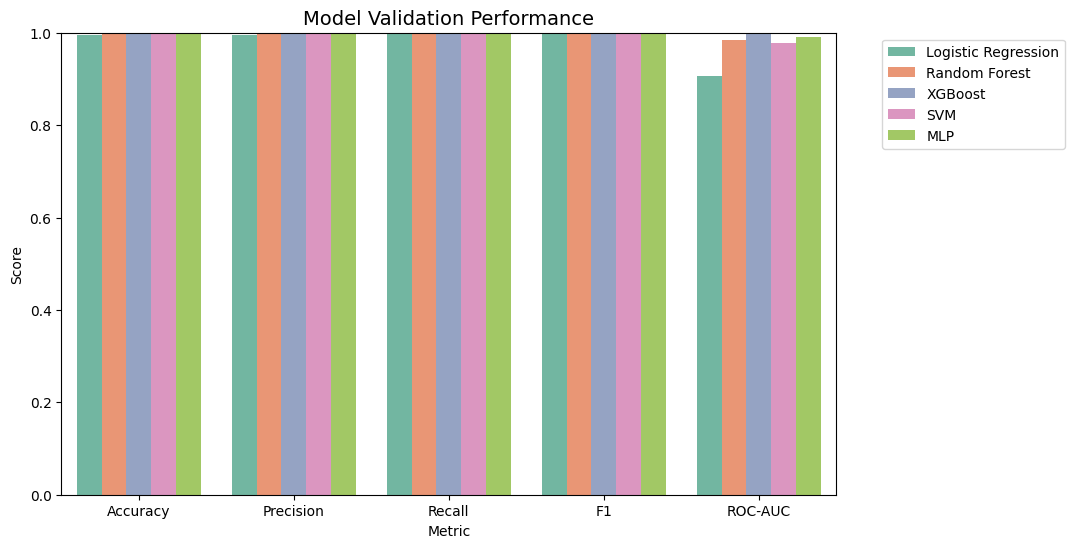

In [ ]:
plot_model_comparison(results_df)


### Metric Trends

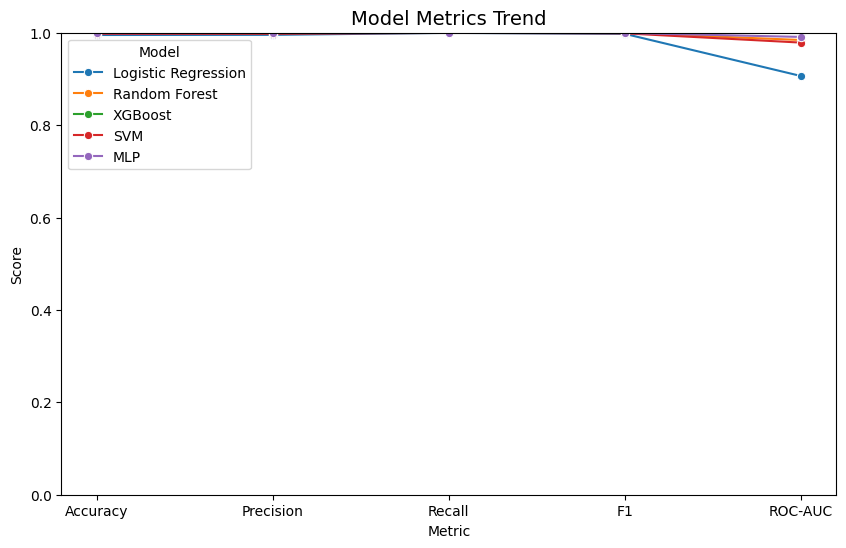

In [ ]:
plot_metric_trends(results_df)

### Metric Heatmap

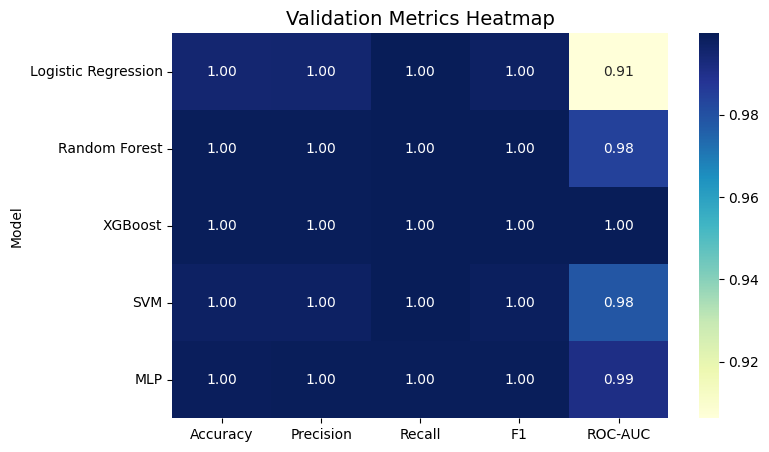

In [ ]:
plot_metric_heatmap(results_df.drop("Confusion Matrix", axis=1))

### Confusion matrix

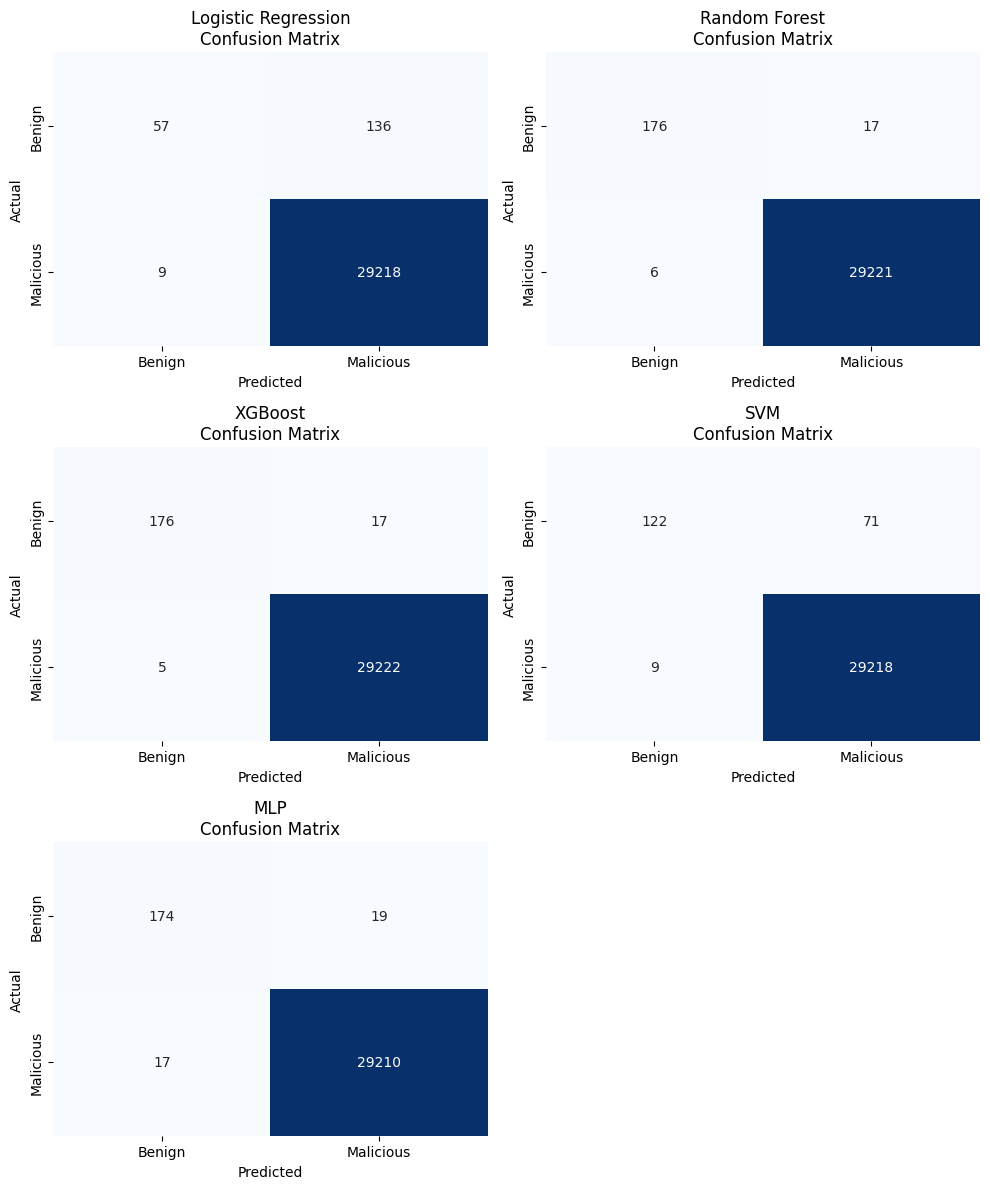

In [ ]:
plot_confusion_matrix(results_df)

## Supervised Learning - Multiclass Classification

### Separate features from label

In [ ]:
X = df.drop(columns=["Label", "Traffic Type", "Traffic Subtype"])
y = df["Traffic Type"] # Target for multilabel classification

### Train-test split

In [ ]:
# Split into train (70%) and val + test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the 30% into val (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (137698, 15)
Validation size: (29507, 15)
Test size: (29507, 15)


### Feature Scaling

In [ ]:
# Create scaler instance
scaler = MinMaxScaler()

# Fit on X_train, transform X_train, X_val, X_test
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
try:
  joblib.dump(scaler, SCALER_PATH)
  print(f"Scaler saved to: {SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/scaler.pkl


### Label Encoding
- Applied to Traffic Subtype

In [ ]:
encoder = LabelEncoder()
y_train_multi = encoder.fit_transform(y_train)  # 8 classes
y_val_multi = encoder.transform(y_val)
y_test_multi = encoder.transform(y_test)

print("Classes:", encoder.classes_)

Classes: ['Audio' 'Background' 'Bruteforce' 'DoS' 'Information Gathering' 'Mirai'
 'Text' 'Video']


### Save the encoder for use later

In [ ]:
# Save the encoder
try:
  joblib.dump(encoder, LABEL_ENCODER_PATH)
  print(f"Scaler saved to: {LABEL_ENCODER_PATH}")
except Exception as e:
  print(f"Error saving encoder: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/label_encoder.pkl


### Model Training and Validation

In [ ]:
# Models to train
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        n_jobs=-1,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
    ),
    "SVM": LinearSVC(dual=False, max_iter=1000, random_state=42),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=100,
        early_stopping=True,
        random_state=42
    )
}

# Apply SMOTE to training set (optional toggle)
use_smote = True
if use_smote:
    smote = SMOTE(sampling_strategy="not majority", random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train_multi)
else:
    X_train_bal, y_train_bal = X_train_scaled, y_train_multi
    print("Skipping SMOTE...")

# Results list
results = []

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
    # Fit on training set
    model.fit(X_train_bal, y_train_bal)

    # Validation performance
    y_val_pred = model.predict(X_val_scaled)
    if hasattr(model, "predict_proba"):
      y_val_prob = model.predict_proba(X_val_scaled)
    else:
      y_val_prob = None

    print(f"\n\n{name} Validation Results:")
    print(classification_report(y_val_multi, y_val_pred, digits=4))

    # Compile metrics
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_val_multi, y_val_pred),
        "Precision (macro)": precision_score(y_val_multi, y_val_pred, average="macro"),
        "Recall (macro)": recall_score(y_val_multi, y_val_pred, average="macro"),
        "F1 (macro)": f1_score(y_val_multi, y_val_pred, average="macro"),
        "Confusion Matrix": confusion_matrix(y_val_multi, y_val_pred)
    }

    # ROC-AUC (macro average, OVR strategy)
    if y_val_prob is not None:
        try:
            metrics["ROC-AUC"] = roc_auc_score(
                y_val_multi,
                y_val_prob,
                multi_class="ovr",
                average="macro"
            )
            print("ROC-AUC (val):", metrics["ROC-AUC"])
        except Exception as e:
            metrics["ROC-AUC"] = None
            print(f"ROC-AUC failed: {e}")
    else:
        metrics["ROC-AUC"] = None

    results.append(metrics)

Training Models:  20%|██        | 1/5 [01:58<07:53, 118.45s/model]



Logistic Regression Validation Results:
              precision    recall  f1-score   support

           0     0.1119    0.5714    0.1871        28
           1     0.1250    1.0000    0.2222         5
           2     0.2762    0.5564    0.3691      1019
           3     0.9766    0.6754    0.7986     23823
           4     0.8646    0.9968    0.9260      2843
           5     0.0973    0.3794    0.1548      1629
           6     0.0943    0.7188    0.1667        32
           7     0.0773    0.5547    0.1356       128

    accuracy                         0.6854     29507
   macro avg     0.3279    0.6816    0.3700     29507
weighted avg     0.8872    0.6854    0.7562     29507

ROC-AUC (val): 0.9174187868951669


Training Models:  40%|████      | 2/5 [04:39<07:09, 143.28s/model]



Random Forest Validation Results:
              precision    recall  f1-score   support

           0     0.9310    0.9643    0.9474        28
           1     1.0000    1.0000    1.0000         5
           2     0.9883    0.9912    0.9897      1019
           3     0.9995    0.9992    0.9994     23823
           4     0.9993    0.9954    0.9974      2843
           5     0.9883    0.9883    0.9883      1629
           6     0.8571    0.9375    0.8955        32
           7     0.8786    0.9609    0.9179       128

    accuracy                         0.9977     29507
   macro avg     0.9553    0.9796    0.9669     29507
weighted avg     0.9978    0.9977    0.9977     29507

ROC-AUC (val): 0.9950001479039656


Training Models:  60%|██████    | 3/5 [05:56<03:46, 113.29s/model]



XGBoost Validation Results:
              precision    recall  f1-score   support

           0     0.7353    0.8929    0.8065        28
           1     0.6000    0.6000    0.6000         5
           2     0.9882    0.9902    0.9892      1019
           3     0.9997    0.9988    0.9993     23823
           4     0.9996    0.9965    0.9981      2843
           5     0.9871    0.9896    0.9884      1629
           6     0.7692    0.9375    0.8451        32
           7     0.8643    0.9453    0.9030       128

    accuracy                         0.9973     29507
   macro avg     0.8679    0.9188    0.8912     29507
weighted avg     0.9975    0.9973    0.9974     29507

ROC-AUC (val): 0.9999477295376464


Training Models:  80%|████████  | 4/5 [07:31<01:46, 106.03s/model]



SVM Validation Results:
              precision    recall  f1-score   support

           0     0.7500    0.5357    0.6250        28
           1     0.1667    1.0000    0.2857         5
           2     0.1328    0.6114    0.2181      1019
           3     0.9749    0.7719    0.8616     23823
           4     0.8341    0.9975    0.9085      2843
           5     0.2832    0.3653    0.3190      1629
           6     0.1159    0.7500    0.2008        32
           7     0.3196    0.4844    0.3851       128

    accuracy                         0.7642     29507
   macro avg     0.4471    0.6895    0.4755     29507
weighted avg     0.8900    0.7642    0.8109     29507



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Training Models: 100%|██████████| 5/5 [27:11<00:00, 326.29s/model]



MLP Validation Results:
              precision    recall  f1-score   support

           0     0.4219    0.9643    0.5870        28
           1     0.1818    0.4000    0.2500         5
           2     0.9668    0.9706    0.9687      1019
           3     0.9989    0.9965    0.9977     23823
           4     0.9906    0.9986    0.9946      2843
           5     0.9666    0.9417    0.9540      1629
           6     0.6250    0.9375    0.7500        32
           7     0.7483    0.8359    0.7897       128

    accuracy                         0.9919     29507
   macro avg     0.7375    0.8806    0.7864     29507
weighted avg     0.9930    0.9919    0.9923     29507

ROC-AUC (val): 0.9982878329322638


### Confusion Matrix

#### Function to plot confusion matrix for multilabel

In [ ]:

def plot_confusion_matrix_multiclass(results_df: pd.DataFrame, class_names: list):
    """
    Generates and displays a confusion matrix for each model (multiclass version).
    """
    n_models = len(results_df)
    n_cols = 2  # two plots per row
    n_rows = int(np.ceil(n_models / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, results_df.iterrows()):
        cm = row["Confusion Matrix"]

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                    xticklabels=class_names,
                    yticklabels=class_names)

        ax.set_title(f"{row['Model']}\nConfusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide unused subplots (if any)
    for i in range(len(results_df), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


#### Confusion Matrix Display

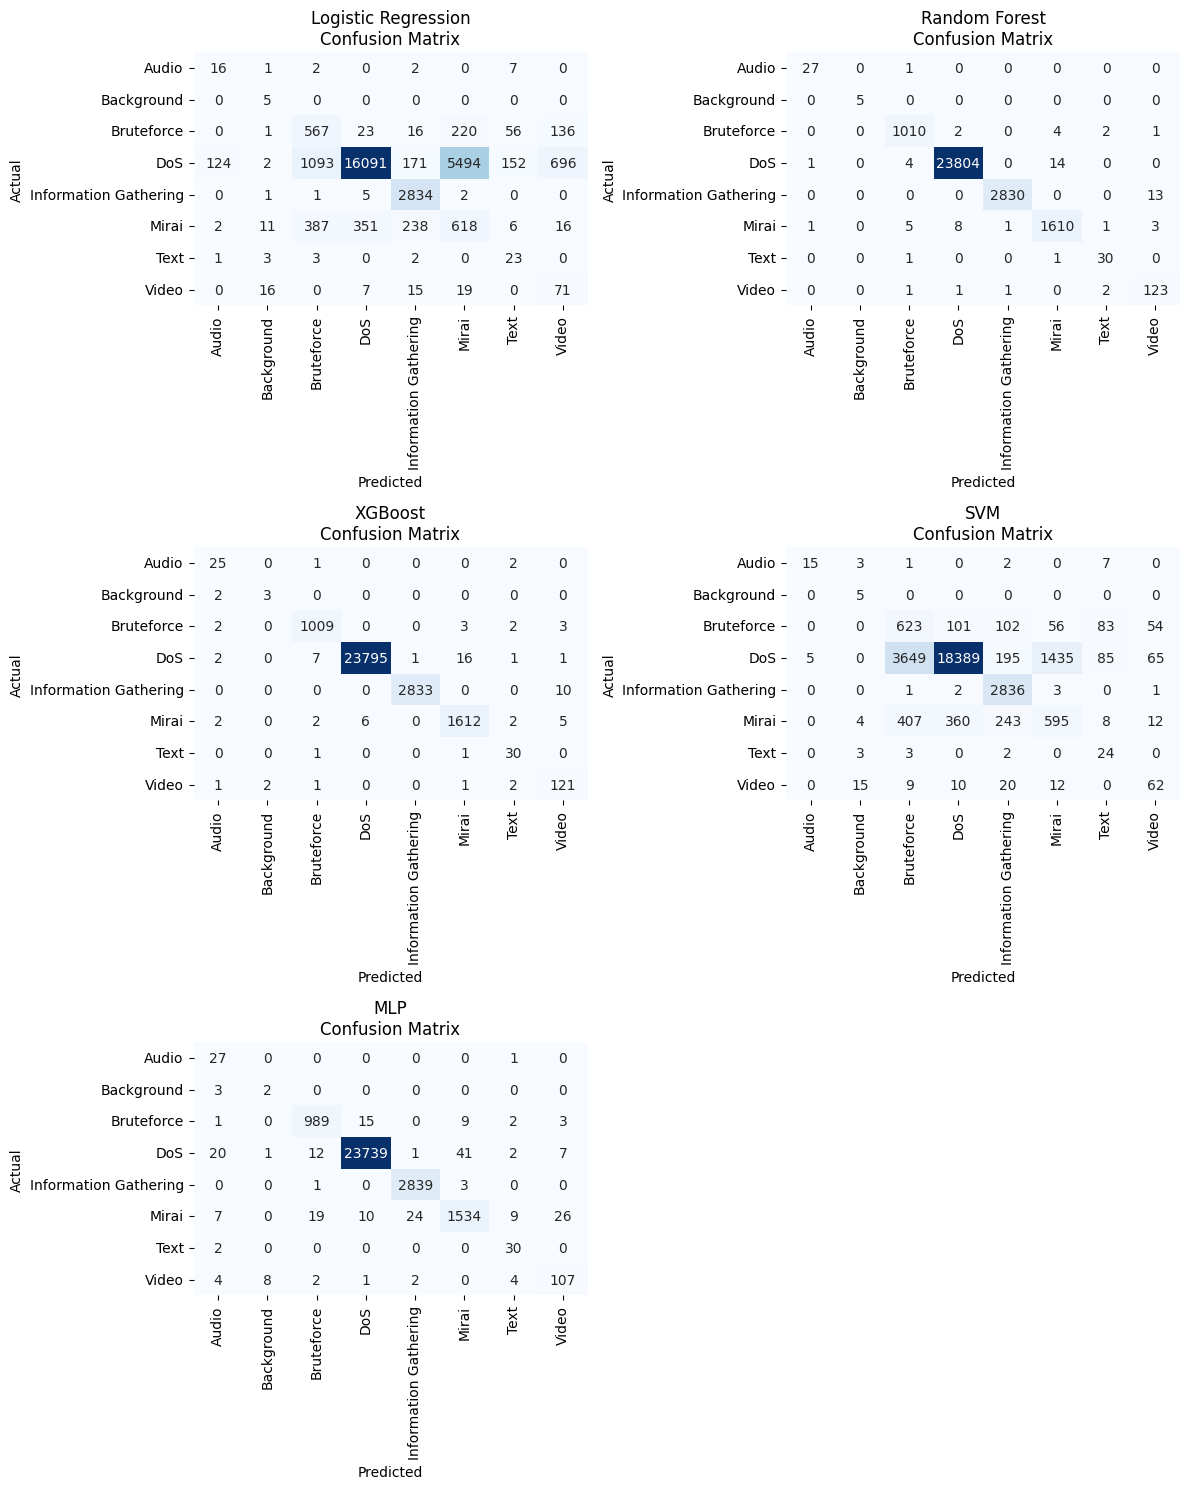

In [ ]:
results_df = pd.DataFrame(results)
class_names = sorted(encoder.classes_)
plot_confusion_matrix_multiclass(results_df, class_names)

## Unsupervised Learning
- The idea for unsupervised learning:
1. Train models only on benign traffic
2. During inference, detect whether new samples deviate significantly to determine anomalies

### Preprocessing
- Split data into benign and malicious

In [ ]:
# Columns to drop for unsupervised learning
cols_to_drop = ["Label", "Traffic Type", "Traffic Subtype"]

# Separate benign from malicious
df_benign = df[df['Label'] == 0].copy()
df_mal = df[df['Label'] == 1].copy()

X_benign = df_benign.drop(columns=cols_to_drop)
X_mal = df_mal.drop(columns=cols_to_drop)

print("Benign data shape:", X_benign.shape)
print("Malicious data shape:", X_mal.shape)

Benign data shape: (1289, 15)
Malicious data shape: (195423, 15)


### Train-test split

In [ ]:
# Split into train and val+test
X_benign_train, X_benign_temp = train_test_split(
    X_benign, test_size=0.30, random_state=42
)

# Split into val+test
X_benign_val, X_benign_test = train_test_split(
    X_benign_temp, test_size=0.50, random_state=42
)

print("Benign Train size:", X_benign_train.shape)
print("Benign Validation size:", X_benign_val.shape)
print("Benign Test size:", X_benign_test.shape)

Benign Train size: (902, 15)
Benign Validation size: (193, 15)
Benign Test size: (194, 15)


### Feature Scaling

In [ ]:
scaler = MinMaxScaler()

# Fit and transform on training data
X_benign_train_scaled = scaler.fit_transform(X_benign_train)

# Transform on testing data
X_benign_val_scaled = scaler.transform(X_benign_val)
X_benign_test_scaled = scaler.transform(X_benign_test)

# Transform malicious data
X_mal_scaled = scaler.transform(X_mal)

### Create mixed testt sets for evaluation

In [ ]:
# Create mixed test set for evaluation
X_test_scaled = np.concatenate((X_benign_test_scaled, X_mal_scaled), axis=0)
y_test_scaled = np.concatenate(
    (np.zeros(X_benign_test_scaled.shape[0]), np.ones(X_mal_scaled.shape[0])),
    axis=0
)

# Small validation mixed sets (benign+malicious)
X_val_scaled = np.concatenate((X_benign_val_scaled, X_mal_scaled), axis=0)
y_val_scaled = np.concatenate(
    (np.zeros(X_benign_val_scaled.shape[0]), np.ones(X_mal_scaled.shape[0])),
    axis=0
)

print("Test set size:", X_test_scaled.shape)
print("Validation set size:", X_val_scaled.shape)

Test set size: (195617, 15)
Validation set size: (195616, 15)


### Model Training and Validation
- Candidate Models
1. One-Class SVM: Learns boundary around benign traffic
2. Isolation Forest: Isolates anomalies by random splits
3. Local Outlier Factor (LOF): Detects density anomalies
4. Elliptic Envelope: Fits an ellipse around the data points
5. Autoencoder (AE): Will be trained to reconstruct benign traffic.

In [ ]:
anomaly_models = {
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42),
    "One-Class SVM": OneClassSVM(kernel="rbf", gamma="scale", nu=0.05),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.05, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(
        novelty=True,
        n_neighbors=20,
        contamination=0.05,
    ),
}

anomaly_results = []

for name, model in anomaly_models.items():
  # Fit the model on benign traffic (scaled)
  model.fit(X_benign_train_scaled)

  # Predict on validation set
  y_val_pred = model.predict(X_val_scaled)
  y_test_pred = model.predict(X_test_scaled)

  # Map outputs
  y_val_pred = np.where(y_val_pred == 1, 0, 1)
  y_test_pred = np.where(y_test_pred == 1, 0, 1)

  # Evaluate
  print(f"\n\n{name} Validation Results:")
  print(classification_report(y_val_scaled, y_val_pred))

  print(f"\n\n{name} Test Results:")
  print(classification_report(y_test_scaled, y_test_pred))

  # Compile metrics
  anomaly_metrics = {
      "Model": name,
      "Accuracy": accuracy_score(y_val_scaled, y_val_pred),
      "Precision": precision_score(y_val_scaled, y_val_pred, average="binary"),
      "Recall": recall_score(y_val_scaled, y_val_pred, average="binary"),
      "F1": f1_score(y_val_scaled, y_val_pred, average="binary"),
      "Confusion Matrix": confusion_matrix(y_val_scaled, y_val_pred),
      "ROC-AUC": roc_auc_score(y_val_scaled, y_val_pred)
  }

  anomaly_results.append(anomaly_metrics)



Isolation Forest Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.92      0.00       193
         1.0       1.00      0.04      0.08    195423

    accuracy                           0.04    195616
   macro avg       0.50      0.48      0.04    195616
weighted avg       1.00      0.04      0.08    195616



Isolation Forest Test Results:
              precision    recall  f1-score   support

         0.0       0.00      0.94      0.00       194
         1.0       1.00      0.04      0.08    195423

    accuracy                           0.04    195617
   macro avg       0.50      0.49      0.04    195617
weighted avg       1.00      0.04      0.08    195617



One-Class SVM Validation Results:
              precision    recall  f1-score   support

         0.0       0.00      0.94      0.00       193
         1.0       1.00      0.29      0.45    195423

    accuracy                           0.29    195616
   macro avg       0